In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import duckdb

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

df = pd.read_csv('../data/events.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

In [ ]:
# Simpler SQL - single pass through data
cohort_sql = """
  WITH events_with_cohort AS (
      SELECT 
          *,
          DATE_TRUNC('week', epoch_ms(timestamp)) as event_week,
          FIRST_VALUE(DATE_TRUNC('week', epoch_ms(timestamp))) 
              OVER (PARTITION BY visitorid ORDER BY timestamp) as cohort
      FROM read_csv_auto('../data/events.csv')
  )
  SELECT
      CAST(cohort AS VARCHAR) as cohort,
      COUNT(DISTINCT visitorid) as total_users,
      COUNT(DISTINCT CASE WHEN event = 'addtocart' THEN visitorid END) as cart_users,
      COUNT(DISTINCT CASE WHEN event = 'transaction' THEN visitorid END) as purchasers,
      ROUND(COUNT(DISTINCT CASE WHEN event = 'addtocart' THEN visitorid END) * 100.0 / 
            COUNT(DISTINCT visitorid), 2) as view_to_cart_pct,
      ROUND(COUNT(DISTINCT CASE WHEN event = 'transaction' THEN visitorid END) * 100.0 / 
            NULLIF(COUNT(DISTINCT CASE WHEN event = 'addtocart' THEN visitorid END), 0), 2) as cart_to_purchase_pct,
      ROUND(COUNT(DISTINCT CASE WHEN event = 'transaction' THEN visitorid END) * 100.0 / 
            COUNT(DISTINCT visitorid), 2) as overall_conversion_pct
  FROM events_with_cohort
  GROUP BY cohort
  ORDER BY cohort
  """

cohort_df = duckdb.query(cohort_sql).df()
print("Done!")
print(cohort_df)

In [ ]:
# Visualize cohort conversion trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Conversion rates over time
cohort_df.plot(x='cohort', y=['view_to_cart_pct', 'cart_to_purchase_pct', 'overall_conversion_pct'], 
               ax=ax1, marker='o', linewidth=2)
ax1.set_title('Conversion Rates by Cohort Over Time (SQL Analysis)', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Cohort (Week)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax1.legend(['View → Cart', 'Cart → Purchase', 'Overall'], fontsize=11)
ax1.grid(alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Number of purchasers by cohort
cohort_df.plot(x='cohort', y='purchasers', kind='bar', ax=ax2, color='#2ecc71', 
               edgecolor='black', linewidth=0.5)
ax2.set_title('Number of Purchasers by Cohort', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Cohort (Week)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Purchasers', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\nKEY INSIGHT:")
print(f"Cohort conversion rates are relatively stable over time,")
print(f"suggesting the drop-off problem is consistent, not improving or degrading.")

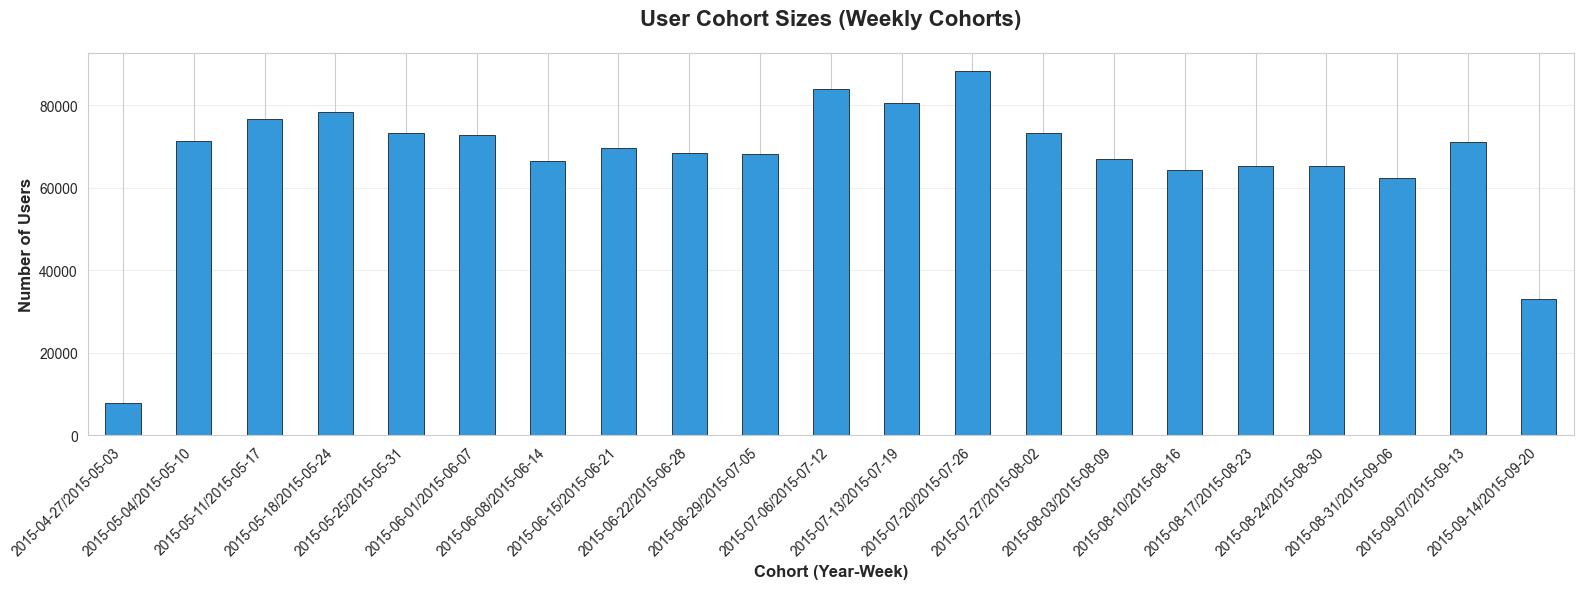


Insight: Average cohort size is 67028 users


In [3]:
# Visualize cohort sizes
fig, ax = plt.subplots(figsize=(16, 6))

cohort_sizes.plot(kind='bar', ax=ax, color='#3498db', edgecolor='black', linewidth=0.5)
ax.set_title('User Cohort Sizes (Weekly Cohorts)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Cohort (Year-Week)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Users', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Rotate labels for readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nInsight: Average cohort size is {cohort_sizes.mean():.0f} users")